In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import multiprocess as mp
from functools import partial


In [2]:
if not os.path.exists("./images/"): 
    os.makedirs("./images/") 

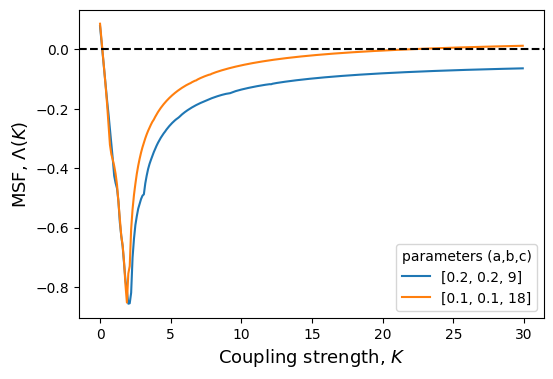

In [3]:
plt.figure(figsize=(6,4))
with open('./data/msf/rossler_msf2.json', 'r') as file:
    data = json.load(file)
plt.plot(data["coupling"], data["msf"],label=str(data["parameters"]))

with open('./data/msf/rossler_msf3.json', 'r') as file:
    data = json.load(file)
plt.plot(data["coupling"], data["msf"], label=str(data["parameters"]))
plt.axhline(0, ls="--", c="k")

plt.ylabel(r"MSF, $\Lambda(K)$", size=13)
plt.xlabel(r"Coupling strength, $K$", size=13)
plt.legend(loc="best", title="parameters (a,b,c)")
#plt.title("Rossler system, y-y coupled")
plt.savefig("./images/rossler_msf.pdf", 
                facecolor="white", bbox_inches="tight", dpi=600)

plt.show()

# Critical points

In [4]:
def RK_step(f, params, ti, p, h):
    """
    Compute a single Runge-Kutta step with the function f, parameters params, 
    at time ti with values given by the vector p and a spacing h.
    """
    k1 = f(ti, p, params)
    k2 = f(ti + 0.5 * h, p + 0.5 * h * k1, params)
    k3 = f(ti + 0.5 * h, p + 0.5 * h * k2, params)
    k4 = f(ti + h, p + h * k3, params)
    
    return p + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def compute_RK4(f, params, p0, t, h, N, frec):
    """
    Compute a Runge-Kutta step with the function f, with parameters params, 
    during time t, with timestep h starting from vector p0, over N iterations, 
    and reset after frec iterations.
    """
    P = np.zeros((2, 6))  # Only store current and next step
    P[0, :] = p0          # Initial condition
    
    num_measurements = N // frec
    enorm = np.zeros(num_measurements)  # initialization of the error norm's vector
    
    # Runge-Kutta
    index = 0
    for it in range(N):
        if it > 0:
            P[0, :] = P[1, :]  # Move next step to current
        
        ti = t[it]
        P[1, :] = RK_step(f, params, ti, P[0, :], h)
        
        # Measure of the error vector norm every frec iterations
        if (it + 1) % frec == 0:
            if index >= num_measurements:
                break
            
            enorm[index] = np.log(np.linalg.norm(P[1, 0:3]))/ (frec * h)  # log of error vector norm divided by elapsed time 
            
            # Normalize the error vector for the next iteration
            P[1, 0:3] = P[1, 0:3] / np.linalg.norm(P[1, 0:3])
            
            index += 1
    
    return enorm

def LyapExp(nu, f, parameters, initc, t, h, N, frec, Tsample):
    """
    Compute the Lyapunov exponent of the dynamical system f(x) with parameters,
    couplings nulist, from an initial condition initc, during N iterations with h timestep, 
    calculated at a frequency frec, and averaged over the last Tsample values.
    """
    # initialization p0(1:3,1) random. p0(4:6,1) initc
    p0 = np.zeros(6)
    p0[3:6] = initc  # Decoupled system
    d = np.random.rand(3)
    p0[0:3] = d/np.linalg.norm(d)  # Error vector normalised

    # E.g. the a,b,c of Rossler or the sigma, rho, beta of Lorenz
    params = (parameters[0], parameters[1], parameters[2], nu)

    enorm = compute_RK4(f, params, p0, t, h, N, frec)
    explya = np.mean(enorm[-Tsample:])# averaged over M #/(tl[-1])
        
    return explya#, P, tl

# Function to compute the Lorenz system
def f(t, p, params):
    dx, dy, dz, x, y, z = p
    a, b, c, nu = params

    return np.array([
        - dy - dz,
        dx + (a-nu) * dy,
        z * dx + (x - c) * dz,  # error
        - y - z,
        x + a * y,
        b + (x - c) * z  # decoupled
    ])

# Load the Rossler initial condition (within the attractor)
initc = [0.1, 0.1, 0.1]

# Time
t0 = 0           # initial t
T = 4000         # Tmax
#N = 2000000      # Number of iterations

#t = np.linspace(t0, T, N)  # vector of time
#h = (T - t0) / N  # delta t (spacing)

#frec = 50  # frequency at which we measure/calculate the Lyapunov exponent
#Tsample = 15000  # Late times used for the average


h=0.001 # step size of Runge Kutta
N = int((T-t0)/h) # total number of iterations
t = np.linspace(t0, T, N) 

dt = 50*h # step size for computing lyap exp
t_last = 3000 # final time to sum to get Max lyap exp
frec = int(dt/h) # freq in number of steps related to dt
Tsample = int(t_last/dt) # final steps to sum to get Max lyap exp related to t_last



In [5]:
%%time
# MSF class II
if __name__ == "__main__":
    #print("msf2 started")
    a,b,c = 0.2, 0.2, 9
    parameters = (a,b,c)
    nulist = [0.153, 0.154, 0.155, 0.156, 0.157]
    #nulist = [[i] for i in nulist]
    
    paral_func1 = partial( LyapExp, f=f, parameters=parameters, \
                          initc=initc, t=t, h=h, N=N, frec=frec, Tsample=Tsample)
     
    with mp.Pool(processes=5) as pool:
        results = pool.map(paral_func1, nulist)
    
    msf_dict = {"coupling":list(nulist),
               "msf":list(results)}
    

CPU times: user 34.3 ms, sys: 72.4 ms, total: 107 ms
Wall time: 50.1 s


In [6]:
df_msf2 = pd.DataFrame(msf_dict)

In [7]:
df_msf2

,coupling,msf
0,0.153,0.001632
1,0.154,0.001142
2,0.155,0.000650
3,0.156,0.000157
4,0.157,-0.000337


In [8]:
%%time
# MSF class III
if __name__ == "__main__":
    #print("msf2 started")
    a,b,c = 0.1, 0.1, 18
    parameters = (a,b,c)
    nulist = [0.166, 0.167, 0.168, 0.179, 21.6, 21.7, 21.8]
    
    paral_func1 = partial( LyapExp, f=f, parameters=parameters, \
                          initc=initc, t=t, h=h, N=N, frec=frec, Tsample=Tsample)
     
    with mp.Pool(processes=7) as pool:
        results = pool.map(paral_func1, nulist)
    
    msf_dict = {"coupling":list(nulist),
               "msf":list(results)}
df_msf3 = pd.DataFrame(msf_dict)
print(df_msf3)

   coupling       msf
0     0.166  0.000494
1     0.167 -0.000033
2     0.168 -0.000559
3     0.179 -0.006367
4    21.600 -0.000227
5    21.700 -0.000019
6    21.800  0.000186
CPU times: user 33.7 ms, sys: 109 ms, total: 143 ms
Wall time: 1min 3s
